# Quantization inference test
https://gist.github.com/martinferianc/d6090fffb4c95efed6f1152d5fde079d

In [2]:
# Architecture
import platform

machine = platform.machine()
architecture = platform.architecture()

print(f"Machine types:{machine}")
print(f"Architecture :{architecture}")

Machine types:x86_64
Architecture :('64bit', 'ELF')


In [4]:
import torch

# Check available quantization backends
available_backends = torch.backends.quantized.supported_engines
print(f"Available Quantization Backends: {available_backends}")

# Check the default quantization backend
default_backend = torch.backends.quantized.engine
print(f"Default Quantization Backend: {default_backend}")

# Print the current backend in use
current_backend = torch.backends.quantized.engine
print(f"Current Quantization Backend: {current_backend}")


Available Quantization Backends: ['qnnpack', 'none', 'x86', 'fbgemm']
Default Quantization Backend: x86
Current Quantization Backend: x86


In [1]:
import torch
import torch.nn as nn
from torch.quantization import quantize_dynamic
import time

# Define the simple neural network (same as before)
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create model instance and set to eval mode
model = SimpleNet()
model.eval()

# Prepare sample input data
input_data = torch.randn(1000, 10)  # Increased batch size for more noticeable timing difference

# Function to measure inference time
def measure_inference_time(model, input_data, num_runs=100):
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_data)
    end_time = time.time()
    return (end_time - start_time) / num_runs

# Measure FP32 inference time
fp32_time = measure_inference_time(model, input_data)

# Quantize the model to INT8
quantized_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Measure INT8 inference time
int8_time = measure_inference_time(quantized_model, input_data)

# Compare outputs, memory usage, and inference time
with torch.no_grad():
    fp32_output = model(input_data)
    int8_output = quantized_model(input_data)

print("FP32 output (first 5):", fp32_output[:5])
print("INT8 output (first 5):", int8_output[:5])

print("\nFP32 model size:", sum(p.numel() for p in model.parameters()) * 4, "bytes")
print("INT8 model size:", sum(p.numel() for p in quantized_model.parameters()) * 1, "bytes")

print(f"\nFP32 average inference time: {fp32_time:.6f} seconds")
print(f"INT8 average inference time: {int8_time:.6f} seconds")
print(f"Speedup: {fp32_time / int8_time:.2f}x")


FP32 output (first 5): tensor([[ 0.3440],
        [-0.0038],
        [ 0.2164],
        [ 0.1589],
        [-0.0345]])
INT8 output (first 5): tensor([[ 0.3355],
        [ 0.0040],
        [ 0.2201],
        [ 0.1595],
        [-0.0303]])

FP32 model size: 964 bytes
INT8 model size: 0 bytes

FP32 average inference time: 0.000155 seconds
INT8 average inference time: 0.000356 seconds
Speedup: 0.43x


## CNN

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data to range [0, 1] and add channel dimension
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define U-Net model

# Define U-Net model for classification
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    # Classification output
    g = layers.GlobalAveragePooling2D()(c5)
    outputs = layers.Dense(10, activation='softmax')(g)

    model = models.Model(inputs, outputs)
    return model

# Prepare model
model = unet_model(input_shape=(28, 28, 1))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=64
)

# Evaluate model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/10


2024-12-19 01:12:02.332507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-12-19 01:12:08.706554: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f29d40ab950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-19 01:12:08.706601: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-19 01:12:08.726776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 01:12:09.005680: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 [==============================] - 30s 15ms/step - loss: 0.4845 - accuracy: 0.8311 - val_loss: 0.0929 - val_accuracy: 0.9742
Epoch 2/10
938/938 [==============================] - 14s 14ms/step - loss: 0.0666 - accuracy: 0.9815 - val_loss: 0.0473 - val_accuracy: 0.9852
Epoch 3/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0470 - accuracy: 0.9869 - val_loss: 0.0344 - val_accuracy: 0.9895
Epoch 4/10
938/938 [==============================] - 14s 14ms/step - loss: 0.0365 - accuracy: 0.9895 - val_loss: 0.0621 - val_accuracy: 0.9817
Epoch 5/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0298 - accuracy: 0.9916 - val_loss: 0.0225 - val_accuracy: 0.9930
Epoch 6/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.0363 - val_accuracy: 0.9885
Epoch 7/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0213 - val_accuracy: 0.9940
Epo

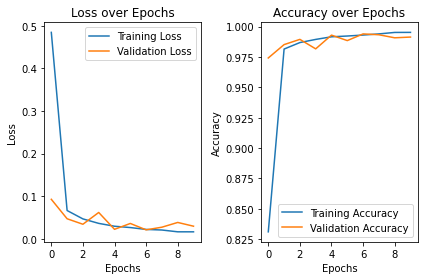

In [7]:
import matplotlib.pyplot as plt

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# CNN With pytorch

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define U-Net model for classification
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Classification output
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.enc2(pool1)
        pool2 = self.pool2(enc2)

        # Bottleneck
        bottleneck = self.bottleneck(pool2)

        # Decoder
        up1 = self.up1(bottleneck)
        dec1 = self.dec1(torch.cat([up1, enc2], dim=1))

        up2 = self.up2(dec1)
        dec2 = self.dec2(torch.cat([up2, enc1], dim=1))

        # Classification
        out = self.classifier(dec2)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss, and optimizer
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluate on test data
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")



Epoch 1/10, Train Loss: 0.8289, Test Loss: 0.1054
Epoch 2/10, Train Loss: 0.0962, Test Loss: 0.0620
Epoch 3/10, Train Loss: 0.0647, Test Loss: 0.0402
Epoch 4/10, Train Loss: 0.0502, Test Loss: 0.0501
Epoch 5/10, Train Loss: 0.0430, Test Loss: 0.0435
Epoch 6/10, Train Loss: 0.0370, Test Loss: 0.0288
Epoch 7/10, Train Loss: 0.0307, Test Loss: 0.0266
Epoch 8/10, Train Loss: 0.0280, Test Loss: 0.0362
Epoch 9/10, Train Loss: 0.0268, Test Loss: 0.0365
Epoch 10/10, Train Loss: 0.0217, Test Loss: 0.0375


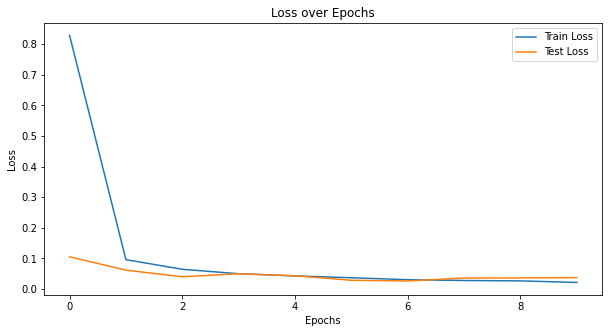

In [10]:
# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Move model to CPU
model = model.to("cpu")



# inference speed calculation

In [1]:
import torch
import torch.nn as nn
import time
from torch.quantization import quantize_dynamic

# Step 1: Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Create a random input tensor
input_data = torch.rand(1000, 784)  # Batch of 1000, input size 784

# Step 2: Initialize the model
model = SimpleModel()

# Simulate training by setting to eval mode
model.eval()

# Step 3: Measure inference time for the original model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = model(input_data)
original_inference_time = time.time() - start_time
print(f"Original model inference time: {original_inference_time:.4f} seconds")

# Step 4: Quantize the model
quantized_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)  # Quantize Linear layers

# Step 5: Measure inference time for the quantized model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = quantized_model(input_data)
quantized_inference_time = time.time() - start_time
print(f"Quantized model inference time: {quantized_inference_time:.4f} seconds")

# Compare the results
speedup = original_inference_time / quantized_inference_time
print(f"Speedup with quantization: {speedup:.2f}x")


Original model inference time: 7.2349 seconds
Quantized model inference time: 0.1780 seconds
Speedup with quantization: 40.65x


## Inference on CNN Model

In [2]:
import torch
import torch.nn as nn
import time
from torch.quantization import quantize_dynamic

# Step 1: Define a CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 1 input channel, 16 output channels
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling

        # Use a dummy input to calculate the flattened size
        dummy_input = torch.zeros(1, 1, 28, 28)  # Example input shape
        with torch.no_grad():
            flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(flattened_size, 128)  # Adjust input size dynamically
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x.numel()  # Total number of elements in the tensor

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create a random input tensor (e.g., batch size 100, 1 channel, 28x28 image)
input_data = torch.rand(100, 1, 28, 28)

# Step 2: Initialize the model
model = CNNModel()

# Simulate training by setting to eval mode
model.eval()

# Step 3: Measure inference time for the original model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = model(input_data)
original_inference_time = time.time() - start_time
print(f"Original CNN model inference time: {original_inference_time:.4f} seconds")

# Step 4: Quantize the model (Dynamic quantization is typically for Linear layers)
quantized_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)  # Quantize Linear layers

# Step 5: Measure inference time for the quantized model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = quantized_model(input_data)
quantized_inference_time = time.time() - start_time
print(f"Quantized CNN model inference time: {quantized_inference_time:.4f} seconds")

# Compare the results
speedup = original_inference_time / quantized_inference_time
print(f"Speedup with quantization: {speedup:.2f}x")


Original CNN model inference time: 8.3112 seconds
Quantized CNN model inference time: 0.4746 seconds
Speedup with quantization: 17.51x


## Setting the backend to FBGEMM

In [5]:
import torch
import torch.nn as nn
import time
from torch.quantization import quantize_dynamic


# Check available backends
available_backends = torch.backends.quantized.supported_engines
print(f"Available Quantization Backends: {available_backends}")

# Set the backend to FBGEMM (if available)
if "fbgemm" in available_backends:
    torch.backends.quantized.engine = "fbgemm"
else:
    print("FBGEMM backend not available on this system.")
    exit()

print(f"Current Quantization Backend: {torch.backends.quantized.engine}")


Available Quantization Backends: ['qnnpack', 'none', 'x86', 'fbgemm']
Current Quantization Backend: fbgemm


In [6]:
# Step 1: Define a CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create a random input tensor (batch size 100, 1 channel, 28x28 image)
input_data = torch.rand(100, 1, 28, 28)

# Step 2: Initialize the model
model = CNNModel()

# Simulate training by setting to eval mode
model.eval()

# Step 3: Measure inference time for the original model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = model(input_data)
original_inference_time = time.time() - start_time
print(f"Original CNN model inference time: {original_inference_time:.4f} seconds")

# Step 4: Quantize the model (Dynamic quantization for Linear layers)
quantized_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Step 5: Measure inference time for the quantized model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = quantized_model(input_data)
quantized_inference_time = time.time() - start_time
print(f"Quantized CNN model inference time: {quantized_inference_time:.4f} seconds")

# Compare the results
speedup = original_inference_time / quantized_inference_time
print(f"Speedup with quantization: {speedup:.2f}x")

Original CNN model inference time: 8.1330 seconds
Quantized CNN model inference time: 0.5532 seconds
Speedup with quantization: 14.70x


## qnnpack

In [7]:
import torch
import torch.nn as nn
import time
from torch.quantization import quantize_dynamic


# Check available backends
available_backends = torch.backends.quantized.supported_engines
print(f"Available Quantization Backends: {available_backends}")

# Set the backend to FBGEMM (if available)
if "fbgemm" in available_backends:
    torch.backends.quantized.engine = "qnnpack"
else:
    print("FBGEMM backend not available on this system.")
    exit()

print(f"Current Quantization Backend: {torch.backends.quantized.engine}")


Available Quantization Backends: ['qnnpack', 'none', 'x86', 'fbgemm']
Current Quantization Backend: qnnpack


In [8]:
# Step 1: Define a CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create a random input tensor (batch size 100, 1 channel, 28x28 image)
input_data = torch.rand(100, 1, 28, 28)

# Step 2: Initialize the model
model = CNNModel()

# Simulate training by setting to eval mode
model.eval()

# Step 3: Measure inference time for the original model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = model(input_data)
original_inference_time = time.time() - start_time
print(f"Original CNN model inference time: {original_inference_time:.4f} seconds")

# Step 4: Quantize the model (Dynamic quantization for Linear layers)
quantized_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Step 5: Measure inference time for the quantized model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = quantized_model(input_data)
quantized_inference_time = time.time() - start_time
print(f"Quantized CNN model inference time: {quantized_inference_time:.4f} seconds")

# Compare the results
speedup = original_inference_time / quantized_inference_time
print(f"Speedup with quantization: {speedup:.2f}x")


Original CNN model inference time: 10.8331 seconds


[W qlinear_dynamic.cpp:247] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Quantized CNN model inference time: 8.6092 seconds
Speedup with quantization: 1.26x


## NONE 

In [9]:
import torch
import torch.nn as nn
import time
from torch.quantization import quantize_dynamic


# Check available backends
available_backends = torch.backends.quantized.supported_engines
print(f"Available Quantization Backends: {available_backends}")

# Set the backend to FBGEMM (if available)
if "fbgemm" in available_backends:
    torch.backends.quantized.engine = "none"
else:
    print("FBGEMM backend not available on this system.")
    exit()

print(f"Current Quantization Backend: {torch.backends.quantized.engine}")


Available Quantization Backends: ['qnnpack', 'none', 'x86', 'fbgemm']
Current Quantization Backend: none


In [10]:
# Step 1: Define a CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create a random input tensor (batch size 100, 1 channel, 28x28 image)
input_data = torch.rand(100, 1, 28, 28)

# Step 2: Initialize the model
model = CNNModel()

# Simulate training by setting to eval mode
model.eval()

# Step 3: Measure inference time for the original model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = model(input_data)
original_inference_time = time.time() - start_time
print(f"Original CNN model inference time: {original_inference_time:.4f} seconds")

# Step 4: Quantize the model (Dynamic quantization for Linear layers)
quantized_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Step 5: Measure inference time for the quantized model
start_time = time.time()
with torch.no_grad():
    for _ in range(100):  # Run inference 100 times
        _ = quantized_model(input_data)
quantized_inference_time = time.time() - start_time
print(f"Quantized CNN model inference time: {quantized_inference_time:.4f} seconds")

# Compare the results
speedup = original_inference_time / quantized_inference_time
print(f"Speedup with quantization: {speedup:.2f}x")


Original CNN model inference time: 8.9904 seconds


RuntimeError: Didn't find engine for operation quantized::linear_prepack NoQEngine

## 8bit quantization

In [1]:
import tensorflow as tf
import numpy as np

# Generate synthetic data
x_train = np.random.rand(5000, 50).astype(np.float32)
y_train = np.random.randint(0, 2, size=(5000, 1))

# Define a bigger and more complex model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(50,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = create_model()
model.fit(x_train, y_train, epochs=10, batch_size=64)

# Convert the model to TFLite with 8-bit quantization
def quantize_model(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Representative dataset function
    def representative_data_gen():
        for _ in range(200):
            yield [np.random.rand(1, 50).astype(np.float32)]
    
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_quant_model = converter.convert()
    
    return tflite_quant_model

quantized_model = quantize_model(model)

# Save the quantized model
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_model)

print("Quantized model saved successfully!")


2025-01-30 23:50:42.985038: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 23:50:47.511159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
79/79 [==============================] - 1s 2ms/step - loss: 0.7734 - accuracy: 0.5110
Epoch 2/10
79/79 [==============================] - 0s 2ms/step - loss: 0.7128 - accuracy: 0.5180
Epoch 3/10
79/79 [==============================] - 0s 1ms/step - loss: 0.7069 - accuracy: 0.5144
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 0.6970 - accuracy: 0.5294
Epoch 5/10
79/79 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5374
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5354
Epoch 7/10
79/79 [==============================] - 0s 1ms/step - loss: 0.6906 - accuracy: 0.5422
Epoch 8/10
79/79 [==============================] - 0s 1ms/step - loss: 0.6863 - accuracy: 0.5440
Epoch 9/10
79/79 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5494
Epoch 10/10
79/79 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.5532
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: /tmp/sraj/tmp120rjol7/assets
/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-01-30 23:51:39.071369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-01-30 23:51:39.071478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-01-30 23:51:39.071797: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp120rjol7
2025-01-30 23:51:39.072855: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-01-30 23:51:39.072876: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp120rjol7
2025-01-30 23:51:39.078187: I tensorflow/compiler/mlir/mlir_graph

Quantized model saved successfully!


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [5]:
import tensorflow as tf
import numpy as np
import time

# Generate synthetic data
x_train = np.random.rand(5000, 50).astype(np.float32)
y_train = np.random.randint(0, 2, size=(5000, 1))

# Define a more complex model with advanced architecture
def create_model():
    inputs = tf.keras.Input(shape=(50,))
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = create_model()
model.fit(x_train, y_train, epochs=15, batch_size=64)

# Convert the model to TFLite with 8-bit quantization
def quantize_model(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Representative dataset function
    def representative_data_gen():
        for _ in range(200):
            yield [np.random.rand(1, 50).astype(np.float32)]
    
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_quant_model = converter.convert()
    
    return tflite_quant_model

quantized_model = quantize_model(model)

# Save the quantized model
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_model)

print("Quantized model saved successfully!")

# Load and test inference
interpreter = tf.lite.Interpreter(model_path="quantized_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run inference on a random sample and measure time
input_data = np.random.rand(1, 50).astype(np.int8)

# Measure baseline inference time
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
quantized_inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

output_data = interpreter.get_tensor(output_details[0]['index'])

# Run inference on the original model for comparison
start_time = time.time()
model.predict(input_data.astype(np.float32))
original_inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

print("Inference output:", output_data)
print(f"Quantized model inference time: {quantized_inference_time:.2f} ms")
print(f"Original model inference time: {original_inference_time:.2f} ms")
print(f"Inference time reduction: {(original_inference_time - quantized_inference_time):.2f} ms")


Epoch 1/15
79/79 [==============================] - 1s 3ms/step - loss: 0.7904 - accuracy: 0.4954
Epoch 2/15
79/79 [==============================] - 0s 2ms/step - loss: 0.7214 - accuracy: 0.5200
Epoch 3/15
79/79 [==============================] - 0s 2ms/step - loss: 0.7163 - accuracy: 0.5040
Epoch 4/15
79/79 [==============================] - 0s 2ms/step - loss: 0.7014 - accuracy: 0.5274
Epoch 5/15
79/79 [==============================] - 0s 2ms/step - loss: 0.6966 - accuracy: 0.5258
Epoch 6/15
79/79 [==============================] - 0s 2ms/step - loss: 0.6963 - accuracy: 0.5312
Epoch 7/15
79/79 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5358
Epoch 8/15
79/79 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5306
Epoch 9/15
79/79 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5556
Epoch 10/15
79/79 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5478
Epoch 11/15
79/79 [

INFO:tensorflow:Assets written to: /tmp/sraj/tmp1g8ggn0h/assets
/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-01-30 23:57:04.239282: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-01-30 23:57:04.239485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-01-30 23:57:04.239678: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp1g8ggn0h
2025-01-30 23:57:04.241505: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-01-30 23:57:04.241527: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp1g8ggn0h
2025-01-30 23:57:04.247310: I tensorflow/cc/saved_model/loader.cc

Quantized model saved successfully!
1/1 [==============================] - 0s 75ms/step
Inference output: [[19]]
Quantized model inference time: 0.09 ms
Original model inference time: 107.65 ms
Inference time reduction: 107.56 ms
